In [1]:
import torch
import segmentation_models_pytorch as smp
from torch import nn
from src.conf.config import CONFIG
from src.dl.inferer import Inferer
from src.dl.lightning_model import SegModel
from src.dl.model_builder import ModelBuilder
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.dl.torch_utils import one_hot, to_device, sobel_hv
from src.dl.torch_utils import *
from src.img_processing.post_processing import *
import matplotlib.pyplot as plt

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [2]:
# get the config file
config = CONFIG

# Set the model to do instance or panoptic segmentation (depends what's in the config.py file)
base_model = ModelBuilder.set_model("Unet", config)

# Insert the model to pytorch lightning framework. (Simplifies the training and other stuff)
lightning_model = SegModel.from_conf(base_model, config)

ckpt = lightning_model.fm.model_checkpoint(config.inference_args.model_weights)
checkpoint = torch.load(ckpt, map_location = lambda storage, loc : storage)
lightning_model.load_state_dict(checkpoint['state_dict'], strict=False)

<All keys matched successfully>

In [4]:
lightning_model.prepare_data()
d = lightning_model.train_dataloader()
f = next(iter(d))
im = f["image"]
yhats = lightning_model(im.float())
target_inst = f["binary_map"].long()
target_type = f["type_map"].long()
inst_weight = f["weight_map"].float()
# xmap = f["xmap"].float()

In [5]:
f.keys()

dict_keys(['image', 'inst_map', 'binary_map', 'type_map', 'weight_map', 'filename'])

In [7]:
i = 1
fig, ax = plt.subplots(1, 3, figsize=(40, 30))
ax = ax.flatten()
ax[0].imshow(yhats["instances"][i, 1, ...].detach().numpy())
ax[1].imshow(yhats["types"][i, 2, ...].detach().numpy())
ax[2].imshow(target_inst[i, ...].detach().numpy())
# ax[3].imshow(yhats["aux"][i, 1, ...].detach().numpy())
# ax[4].imshow(yhats["aux"][i, 0, ...].detach().numpy())
# ax[5].imshow(xmap[i, ...].detach().numpy())

IndexError: index 3 is out of bounds for axis 0 with size 3

In [6]:
print(yhats["instances"].shape)
print(yhats["types"].shape)
print(target_inst.shape)
print(target_type.shape)
print(inst_weight.shape)
yhati = yhats["instances"]
yhat = yhats["types"]
target = target_type
yhatt = yhats["types"]
target = target_type
yhat_soft = F.softmax(yhat, dim=1)


torch.Size([6, 2, 256, 256])
torch.Size([6, 5, 256, 256])
torch.Size([6, 256, 256])
torch.Size([6, 256, 256])
torch.Size([6, 256, 256])


In [7]:
target_hover = torch.stack([f["xmap"], f["ymap"]], dim=1)

In [8]:
target_hover.shape

torch.Size([6, 2, 256, 256])

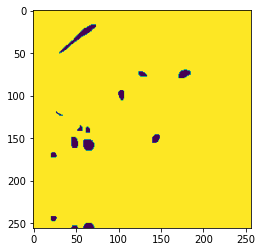

In [9]:
plt.imshow(one_hot(target_inst, n_classes=2)[1, 0, ...])

In [10]:
def gen_sobel_kernel(size: int, device: Optional[torch.device] = None) -> torch.Tensor:
    """
    Generates a sobel kernel of size (size*size)

    Args:
        size (int): an odd integer that specifies the size of the kernel
        device (torch.device): 'cpu' or 'gpu'

    Returns:
        torch.Tensor kernel matrix
    """
    assert size % 2 == 1, 'Must be odd, get size=%d' % size

    range_h = torch.arange(-size//2+1, size//2+1, dtype=torch.float32, device=device)
    range_v = torch.arange(-size//2+1, size//2+1, dtype=torch.float32, device=device)
    h, v = torch.meshgrid(range_h, range_v)
    kernel_h = h / (h*h + v*v + 1e-7)
    kernel_v = v / (h*h + v*v + 1e-7)
    kernel_h = kernel_h.flip(0).unsqueeze(0).unsqueeze(0)
    kernel_v = kernel_v.flip(1).unsqueeze(0).unsqueeze(0)

    return kernel_h, kernel_v            

mh, mv = gen_sobel_kernel(5)


# mh = tf.constant(mh, dtype=tf.float32)
# mv = tf.constant(mv, dtype=tf.float32)
# 
# mh = tf.reshape(mh, [5, 5, 1, 1])
# mv = tf.reshape(mv, [5, 5, 1, 1])
# 
# central difference to get gradient, ignore the boundary problem  
# h = tf.expand_dims(l[...,h_ch], axis=-1)  # NHWC
# v = tf.expand_dims(l[...,v_ch], axis=-1)  
# dh = tf.nn.conv2d(h, mh, strides=[1, 1, 1, 1], padding='SAME')
# dv = tf.nn.conv2d(v, mv, strides=[1, 1, 1, 1], padding='SAME')
# output = tf.concat([dh, dv], axis=-1)

In [11]:
mh

tensor([[[[ 0.2500,  0.4000,  0.5000,  0.4000,  0.2500],
          [ 0.2000,  0.5000,  1.0000,  0.5000,  0.2000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [-0.2000, -0.5000, -1.0000, -0.5000, -0.2000],
          [-0.2500, -0.4000, -0.5000, -0.4000, -0.2500]]]])

In [12]:
mv

tensor([[[[ 0.2500,  0.2000,  0.0000, -0.2000, -0.2500],
          [ 0.4000,  0.5000,  0.0000, -0.5000, -0.4000],
          [ 0.5000,  1.0000,  0.0000, -1.0000, -0.5000],
          [ 0.4000,  0.5000,  0.0000, -0.5000, -0.4000],
          [ 0.2500,  0.2000,  0.0000, -0.2000, -0.2500]]]])

In [13]:
spatial_pad = [mh.size(2) // 2,
               mh.size(2) // 2,
               mh.size(3) // 2,
               mh.size(3) // 2]

pad_yhat = F.pad(yhati[:, 1, ...].unsqueeze(1), spatial_pad, "replicate")
d1 = F.conv2d(pad_yhat, mv)
d2 = F.conv2d(pad_yhat, mh)
d = torch.stack([d1.squeeze(1), d2.squeeze(1)], dim=1)

In [14]:
pred_grad = sobel_hv(yhati[:, 1, ...], 5)
focus = tt = torch.stack([target_inst, target_inst], dim=1)
loss = pred_grad -target_hover
loss = focus*(loss*loss)
loss = torch.sqrt(loss)
# losss = loss.sum() / focus.clamp_min(1e-7).sum()
losss = loss.sum() / (focus.sum() + 1e-7)

In [15]:
yhat - target

RuntimeError: The size of tensor a (5) must match the size of tensor b (6) at non-singleton dimension 1

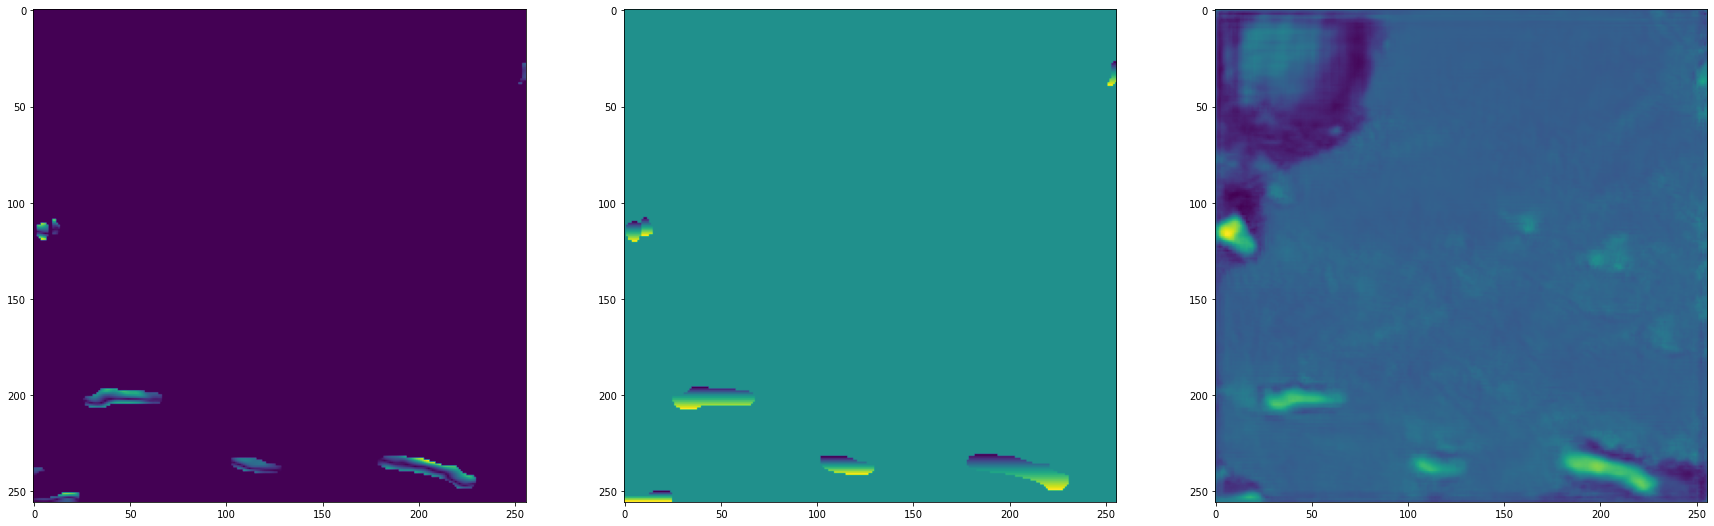

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(30, 30))
ax[0].imshow(loss[3, 0, ...].detach().numpy())
ax[1].imshow(target_hover[3, 1, ...].detach().numpy())
ax[2].imshow(yhati[3, 1, ...].detach().numpy())

In [14]:
tt = torch.stack([target_inst, target_inst], dim=1)
d = d*tt

In [15]:
d.shape

torch.Size([6, 2, 256, 256])

In [16]:
mh.size()

torch.Size([1, 1, 5, 5])

In [17]:
d.shape

torch.Size([6, 2, 256, 256])

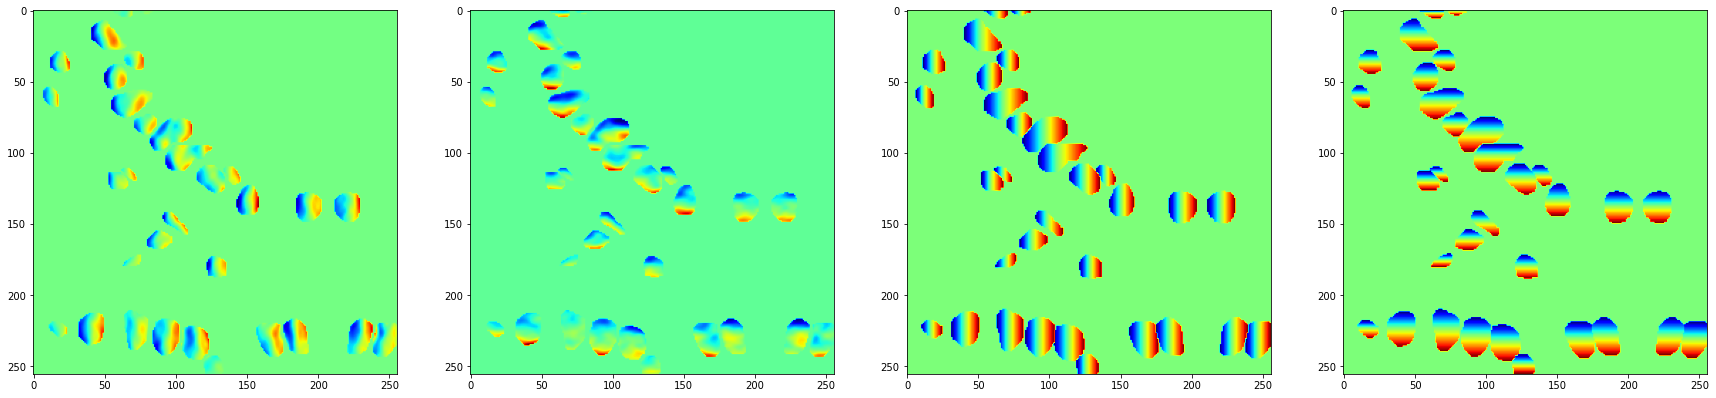

In [93]:
fig, ax = plt.subplots(1,4, figsize=(30, 30))
ax[0].imshow(d[1, 0, ...].detach().numpy(), cmap="jet")
ax[1].imshow(d[1, 1, ...].detach().numpy(), cmap="jet")
ax[2].imshow(target_hover[1, 0, ...].detach().numpy(), cmap="jet")
ax[3].imshow(target_hover[1, 1, ...].detach().numpy(), cmap="jet")

In [100]:
hh = yhati[:, 0, ...].unsqueeze(1)
vv = yhati[:, 1, ...].unsqueeze(1)

In [101]:
hh.shape

torch.Size([6, 1, 256, 256])

In [76]:
torch.nn.Conv2d()

torch.Size([5, 5, 1, 1])

In [77]:
kernel_flip = kernel.flip(-3)

In [78]:
kernel_flip

tensor([[[[-0.2500]],

         [[-0.4000]],

         [[-0.5000]],

         [[-0.4000]],

         [[-0.2500]]],


        [[[-0.2000]],

         [[-0.5000]],

         [[-1.0000]],

         [[-0.5000]],

         [[-0.2000]]],


        [[[ 0.0000]],

         [[ 0.0000]],

         [[ 0.0000]],

         [[ 0.0000]],

         [[ 0.0000]]],


        [[[ 0.2000]],

         [[ 0.5000]],

         [[ 1.0000]],

         [[ 0.5000]],

         [[ 0.2000]]],


        [[[ 0.2500]],

         [[ 0.4000]],

         [[ 0.5000]],

         [[ 0.4000]],

         [[ 0.2500]]]])

In [47]:
spatial_pad = [kernel.size(1) // 2,
               kernel.size(1) // 2,
               kernel.size(2) // 2,
               kernel.size(2) // 2]

In [50]:
g = F.pad(yhati.reshape(b * c, 1, h, w), spatial_pad, 'replicate')[:, :, None]

In [55]:
F.conv3d(g, kernel_flip, padding=0).view(b, c, out_channels, h, w)

RuntimeError: expected stride to be a single integer value or a list of 2 values to match the convolution dimensions, but got stride=[1, 1, 1]

In [ ]:
sobel_kernel_h = torch.Tensor([
    
])

In [27]:
size = 5
range_h = torch.arange(-size//2+1, size//2+1, dtype=torch.float32)
range_v = torch.arange(-size//2+1, size//2+1, dtype=torch.float32)
h, v = torch.meshgrid(range_h, range_v)
kernel_h = h / (h*h + v*v + 1e-7)
kernel_v = h / (h*h + v*v + 1e-7)

In [28]:
kernel_h

tensor([[-0.2500, -0.4000, -0.5000, -0.4000, -0.2500],
        [-0.2000, -0.5000, -1.0000, -0.5000, -0.2000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.2000,  0.5000,  1.0000,  0.5000,  0.2000],
        [ 0.2500,  0.4000,  0.5000,  0.4000,  0.2500]])

In [18]:
g = np.array([
        [-1., -2., 0., 2., 1.],
        [-2., -4., 0., 4., 2.],
        [0., 0., 0., 0., 0.],
        [2., 4., 0., -4., -2.],
        [1., 2., 0., -2., -1.]
    ])

f = np.array([        
        [-1., 0., 2., 0., -1.],
        [-4., 0., 8., 0., -4.],
        [-6., 0., 12., 0., -6.],
        [-4., 0., 8., 0., -4.],
        [-1., 0., 2., 0., -1.]])

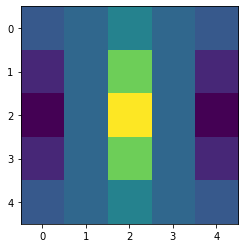

In [20]:
plt.imshow(f)

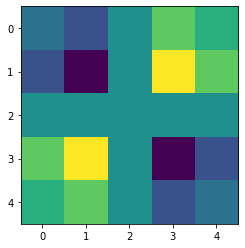

In [16]:
plt.imshow(g)

In [21]:
mh

array([[-0.25, -0.2 ,  0.  ,  0.2 ,  0.25],
       [-0.4 , -0.5 ,  0.  ,  0.5 ,  0.4 ],
       [-0.5 , -1.  ,  0.  ,  1.  ,  0.5 ],
       [-0.4 , -0.5 ,  0.  ,  0.5 ,  0.4 ],
       [-0.25, -0.2 ,  0.  ,  0.2 ,  0.25]], dtype=float32)

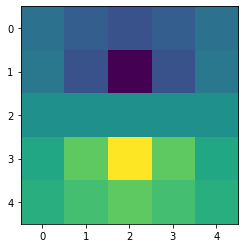

In [13]:
plt.imshow(mv)

In [12]:
from src.dl.torch_utils import *
# tensor_to_ndarray(target).shape
g = tensor_to_ndarray(torch.argmax(yhat_soft, dim=1))

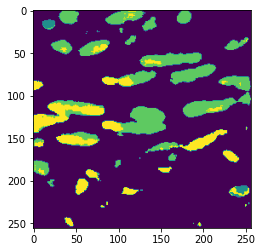

In [21]:
plt.imshow(g[..., 3])

In [5]:
yhat_soft.shape

torch.Size([6, 5, 256, 256])

In [6]:
# n_classes = yhat_soft.shape[1]
# one_hot = torch.zeros(target.shape[0], n_classes, *target.shape[1:], device=target.device, dtype=target.dtype)

In [6]:
target.shape

torch.Size([6, 256, 256])

In [8]:
# one_hot.scatter_(dim=1, index=target.unsqueeze(1), value=1.0).shape

In [9]:
target_one_hot = one_hot(target, n_classes=yhat_soft.shape[1])
class_weights = torch.Tensor([0.2, 0.8])
w = class_weights.expand([256, 256, 2]).permute(2, 0, 1)
# entropy = -torch.sum(to_device(w)*(target_one_hot * torch.log(yhat.clamp(min=1e-7, max=1.0))), dim=1)
# entropyy = to_device(w)*(torch.log(yhat))

In [10]:
o = (yhat_soft*one_hot(target, n_classes=yhat_soft.shape[1]))

In [28]:
pre_bincount = target + torch.argmax(yhat_soft, dim=1)*yhat_soft.shape[1]
pre_bincount_vec = pre_bincount.view(yhat_soft.shape[0], -1)

In [30]:
num_classes = yhat_soft.shape[1]
batch_size = yhat_soft.shape[0]
confusion_list = []
for iter_id in range(batch_size):
    pb = pre_bincount_vec[iter_id]
    bin_count = torch.bincount(pb, minlength=num_classes**2)
    confusion_list.append(bin_count)

In [35]:
confusion_vec = torch.stack(confusion_list)

In [38]:
confusion_mat = confusion_vec.view(batch_size, num_classes, num_classes).to(torch.float32)

In [41]:
conf_mat = confusion_mat

In [61]:
conf_mat.shape

torch.Size([6, 5, 5])

In [72]:
f = one_hot(target, n_classes= num_classes)*one_hot(torch.argmax(yhat_soft, dim=1), n_classes=num_classes)
f = f.long()

In [74]:
torch.sum(target*torch.argmax(yhat_soft, dim=1))

tensor(602942)

In [73]:
torch.sum(f.long())

tensor(379010)

In [43]:
sum_over_row = torch.sum(conf_mat, dim=1)
sum_over_col = torch.sum(conf_mat, dim=2)
conf_mat_diag = torch.diagonal(conf_mat, dim1=-2, dim2=-1)
denominator = sum_over_row + sum_over_col - conf_mat_diag

In [56]:
eps = 1e-7
ious = (conf_mat_diag + eps) / (denominator + eps).clamp_min(eps)

In [59]:
ious.mean()

tensor(0.9099)

In [76]:
from catalyst.dl import utils
from src.dl.torch_utils import *

accuracy = utils.metrics.accuracy(
    argmax_and_flatten(yhat_soft, "softmax"), target.view(1, -1)
)

In [78]:
accuracy[0]

tensor(0.9639)

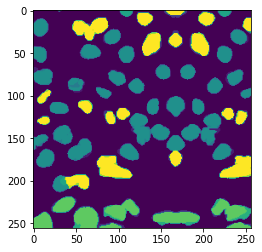

In [23]:
plt.imshow(pre_bincount[0, ...])

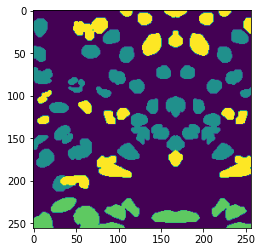

In [24]:
plt.imshow(target[0, ...])

In [ ]:
dims = (1, 2, 3)
intersection = torch.sum(o, dims)
cardinality = torch.sum(yhat_soft + target_one_hot, dims)

In [ ]:
intersection

In [ ]:
cardinality

In [ ]:
dice_score = 2. * intersection / (cardinality + 1e-6)
dice_score

In [ ]:
i = 4
a = (yhat_soft + target_one_hot)
dd = binarize(np.argmax(tensor_to_ndarray(a), axis=-1)[i, ...])
bb = binarize(np.argmax(tensor_to_ndarray(o), axis=-1)[i, ...])
fig, ax = plt.subplots(2, 3, figsize=(14,19))
ax = ax.flatten()
ax[0].imshow(bb)
ax[1].imshow(dd)
ax[2].imshow(np.argmax(tensor_to_ndarray(yhat_soft), axis=-1)[i, ...])
ax[3].imshow(tensor_to_ndarray(torch.log(inst_weight), channel=i))
ax[4].imshow(tensor_to_ndarray(entropy, channel=i)*(3.5**tensor_to_ndarray(torch.log(inst_weight), channel=i)))
ax[5].imshow(tensor_to_ndarray(entropy, channel=i))

In [4]:
p = lightning_model.fm.databases["train"][256]

48
48


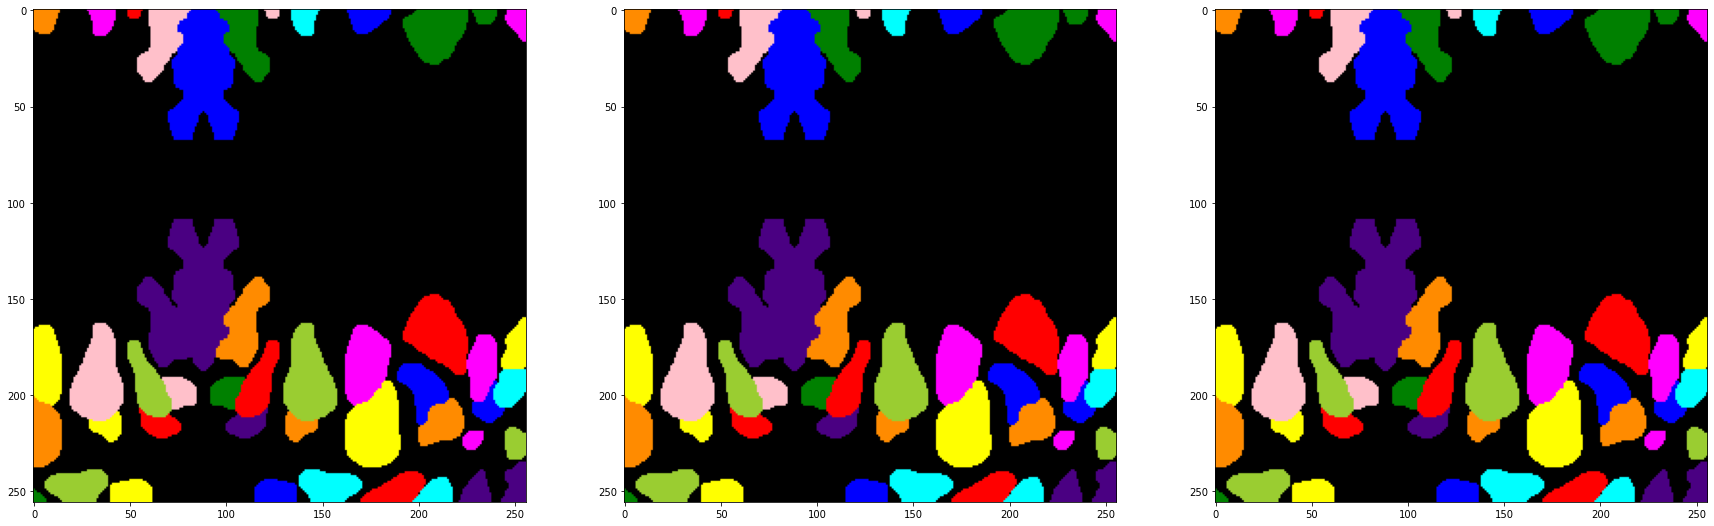

In [6]:
from src.img_processing.pre_processing import *
from src.img_processing.process_utils import *
from skimage.color import label2rgb

i=0
im, inst, type = lightning_model.fm.read_hdf5_patch(p.as_posix(), i)
finst = fix_mirror_padding(inst)
ffinst = fix_mirror_padding(inst)
print(len(np.unique(ffinst)))
print(len(np.unique(finst)))
fig, ax = plt.subplots(1, 3, figsize=(30, 30))
ax[0].imshow(label2rgb(finst, bg_label=0))
ax[1].imshow(label2rgb(ffinst, bg_label=0))
ax[2].imshow(label2rgb(inst, bg_label=0))

In [15]:
fixed_ann = fix_mirror_padding(inst)
crop_ann = cropping_center(fixed_ann, (256, 256))

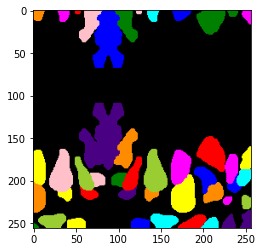

In [16]:
plt.imshow(label2rgb(crop_ann, bg_label=0))

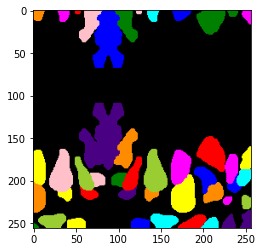

In [18]:
crop_ann = morph.remove_small_objects(crop_ann, min_size=30)
plt.imshow(label2rgb(crop_ann, bg_label=0))

In [53]:
x_map = np.zeros(inst.shape[:2], dtype=np.float32)
y_map = np.zeros(inst.shape[:2], dtype=np.float32)

inst_list = list(np.unique(crop_ann))
inst_list.remove(0)  # 0 is background

for inst_id in inst_list:
    inst_map = np.array(crop_ann == inst_id, np.int32)

    y1, y2, x1, x2 = bounding_box(inst_map)
    y1 = y1 - 2 if y1 - 2 >= 0 else y1
    x1 = x1 - 2 if x1 - 2 >= 0 else x1
    x2 = x2 + 2 if x2 + 2 <= inst_map.shape[1] - 1 else x2
    y2 = y2 + 2 if y2 + 2 <= inst_map.shape[0] - 1 else y2

    inst_map = inst_map[y1:y2, x1:x2]

    # if inst_map.shape[0] < 2 or inst_map.shape[1] < 2:
    #     continue

    # instance center of mass, rounded to nearest pixel
    inst_com = list(ndi.measurements.center_of_mass(inst_map))

    print(inst_com)
    inst_com[0] = int(inst_com[0] + 0.5)
    inst_com[1] = int(inst_com[1] + 0.5)

    inst_x_range = np.arange(1, inst_map.shape[1]+1)
    inst_y_range = np.arange(1, inst_map.shape[0]+1)
    # shifting center of pixels grid to instance center of mass
    inst_x_range -= inst_com[1]
    inst_y_range -= inst_com[0]

    inst_x, inst_y = np.meshgrid(inst_x_range, inst_y_range)

    # remove coord outside of instance
    inst_x[inst_map == 0] = 0
    inst_y[inst_map == 0] = 0
    inst_x = inst_x.astype('float32')
    inst_y = inst_y.astype('float32')

    # normalize min into -1 scale
    if np.min(inst_x) < 0:
        inst_x[inst_x < 0] /= (-np.amin(inst_x[inst_x < 0]))
    if np.min(inst_y) < 0:
        inst_y[inst_y < 0] /= (-np.amin(inst_y[inst_y < 0]))
    # normalize max into +1 scale
    if np.max(inst_x) > 0:
        inst_x[inst_x > 0] /= (np.amax(inst_x[inst_x > 0]))
    if np.max(inst_y) > 0:
        inst_y[inst_y > 0] /= (np.amax(inst_y[inst_y > 0]))

    ####
    x_map_box = x_map[y1:y2, x1:x2]
    x_map_box[inst_map > 0] = inst_x[inst_map > 0]

    y_map_box = y_map[y1:y2, x1:x2]
    y_map_box[inst_map > 0] = inst_y[inst_map > 0]



[10.771014492753624, 20.971014492753625]
[34.82932288752099, 20.0]
[26.718079673135854, 16.876404494382022]
[5.6455696202531644, 9.563291139240507]
[11.715469613259668, 18.531767955801104]
[13.112195121951219, 9.331707317073171]
[5.397350993377484, 5.675496688741722]
[9.119791666666666, 14.010416666666666]
[16.42733564013841, 14.070934256055363]
[10.057471264367816, 18.79080459770115]
[1.8235294117647058, 5.117647058823529]
[14.610503282275712, 15.12253829321663]
[8.054852320675106, 12.548523206751055]
[6.236641221374046, 8.061068702290076]
[3.0930232558139537, 8.255813953488373]
[12.043243243243243, 11.027027027027026]
[14.744471744471744, 14.034398034398034]
[11.134057971014492, 10.246376811594203]
[9.32579185520362, 11.149321266968325]
[10.212121212121213, 6.957575757575758]
[10.75609756097561, 12.487804878048781]
[15.547058823529412, 9.770588235294118]
[9.820987654320987, 11.518518518518519]
[6.222222222222222, 6.944444444444445]
[5.9375, 2.3125]
[36.46097046413502, 20.0]
[21.19111

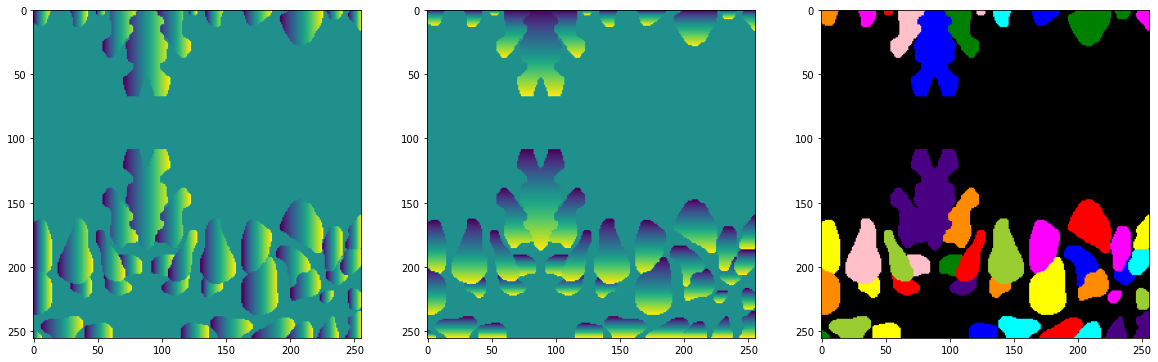

In [54]:
fig, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(x_map)
ax[1].imshow(y_map)
ax[2].imshow(label2rgb(crop_ann, bg_label=0))

In [61]:
# ported from https://github.com/vqdang/hover_net/blob/master/src/loader/augs.py
def gen_hv_maps(inst_map: np.ndarray, crop_shape: Tuple[int] = (256, 256)) -> np.ndarray:
    """
        Input annotation must be of original shape.
        
        The map is calculated only for instances within the crop portion
        but based on the original shape in original image.
    
        Perform following operation:
        Obtain the horizontal and vertical distance maps for each
        nuclear instance.
    """
    fixed_ann = fix_mirror_padding(inst_map)

    # re-cropping with fixed instance id map
    # (if output from network smaller than input)
    crop_ann = cropping_center(fixed_ann, crop_shape)
    crop_ann = morph.remove_small_objects(crop_ann, min_size=30)

    x_map = np.zeros(inst_map.shape[:2], dtype=np.float32)
    y_map = np.zeros(inst_map.shape[:2], dtype=np.float32)

    inst_list = list(np.unique(crop_ann))
    inst_list.remove(0)  # 0 is background
    for inst_id in inst_list:
        inst = np.array(crop_ann == inst_id, np.int32)
        y1, y2, x1, x2 = bounding_box(inst)
        y1 = y1 - 2 if y1 - 2 >= 0 else y1
        x1 = x1 - 2 if x1 - 2 >= 0 else x1
        x2 = x2 + 2 if x2 + 2 <= inst_map.shape[1] - 1 else x2
        y2 = y2 + 2 if y2 + 2 <= inst_map.shape[0] - 1 else y2
        inst = inst[y1:y2, x1:x2]

        # instance center of mass, rounded to nearest pixel
        inst_com = list(ndi.measurements.center_of_mass(inst))
        inst_com[0] = int(inst_com[0] + 0.5)
        inst_com[1] = int(inst_com[1] + 0.5)

        inst_x_range = np.arange(1, inst.shape[1]+1)
        inst_y_range = np.arange(1, inst.shape[0]+1)

        # shifting center of pixels grid to instance center of mass
        inst_x_range -= inst_com[1]
        inst_y_range -= inst_com[0]

        inst_x, inst_y = np.meshgrid(inst_x_range, inst_y_range)

        # remove coord outside of instance
        inst_x[inst == 0] = 0
        inst_y[inst == 0] = 0
        inst_x = inst_x.astype('float32')
        inst_y = inst_y.astype('float32')

        # normalize min into -1 scale
        if np.min(inst_x) < 0:
            inst_x[inst_x < 0] /= (-np.amin(inst_x[inst_x < 0]))
        if np.min(inst_y) < 0:
            inst_y[inst_y < 0] /= (-np.amin(inst_y[inst_y < 0]))
        # normalize max into +1 scale
        if np.max(inst_x) > 0:
            inst_x[inst_x > 0] /= (np.amax(inst_x[inst_x > 0]))
        if np.max(inst_y) > 0:
            inst_y[inst_y > 0] /= (np.amax(inst_y[inst_y > 0]))

        ####
        x_map_box = x_map[y1:y2, x1:x2]
        x_map_box[inst > 0] = inst_x[inst > 0]

        y_map_box = y_map[y1:y2, x1:x2]
        y_map_box[inst > 0] = inst_y[inst > 0]

    return {
        "ymap":y_map,
        "xmap":x_map
    }




In [63]:
ff = gen_hv_maps(inst)

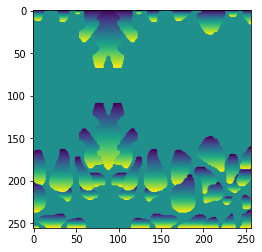

In [66]:
plt.imshow(ff["ymap"])